In [50]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-log-query-length") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [51]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-log-query-length>

In [52]:
from pathlib import Path

# TODO: For final evaluation, use the full corpus.
# corpus_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/corpus")
# queries_dir = corpus_dir / "queries-2023-02-14"
corpus_dir = Path(
    "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/sample-corpus")
queries_dir = corpus_dir / "queries-2023-02-16"
queries_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused/sample-corpus/queries-2023-02-16')

In [53]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [54]:
def group(query: dict) -> tuple:
    query_text = query["url_query"]
    return query["service"], query["language"], len(query_text)

In [55]:
from json import loads
from pandas import DataFrame

counts = sc.textFile(f"file://{queries_dir}") \
    .map(lambda line: loads(line)) \
    .filter(lambda query: query["url_query"] is not None) \
    .keyBy(lambda query: query["id"]) \
    .mapValues(group) \
    .countByValue()

In [56]:
df = DataFrame([
    {
        "service": service,
        "language": language,
        "query_length": query_length,
        "count": count,
    }
    for (_, (service, language, query_length)), count in counts.items()
])
df

,service,language,query_length,count
0,google,no,17,1
1,google,None,18,1
2,google,en,19,1
3,google,lb,24,1
4,google,no,17,1
...,...,...,...,...
163891,yandex,en,11,1
163892,yandex,en,11,1
163893,yandex,en,11,1
163894,yandex,en,11,1


In [57]:
df["language"].value_counts()

en    20880
zh    19733
ga     8326
ja     4979
ru     4553
      ...  
ka        4
ta        2
my        1
ml        1
te        1
Name: language, Length: 96, dtype: int64

In [58]:
top_services = df.groupby("service")["count"].sum().sort_values(ascending=False).head(5).index
top_services

Index(['google', 'baidu', 'twitter', 'youtube', 'stackoverflow'], dtype='object', name='service')

In [59]:
df_plot = df.copy()
df_plot.loc[
    ~df_plot["service"].isin(top_services),
    "service",
] = "other"
df_plot = df_plot.groupby(["service", "query_length"])["count"].sum().reset_index()
df_plot

,service,query_length,count
0,baidu,1,8
1,baidu,2,441
2,baidu,3,498
3,baidu,4,810
4,baidu,5,561
...,...,...,...
1062,youtube,110,1
1063,youtube,112,1
1064,youtube,115,1
1065,youtube,184,1


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


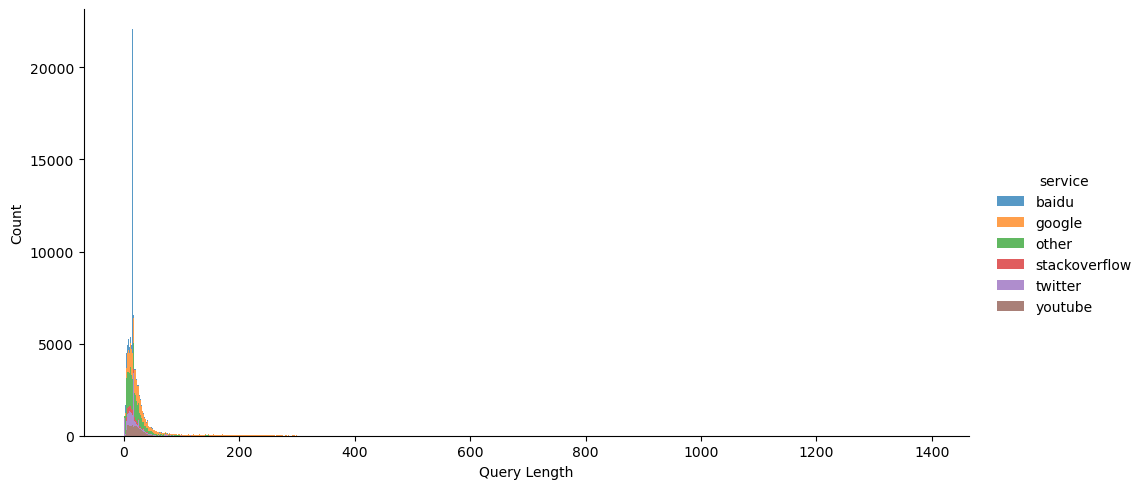

In [44]:
from seaborn import displot

plot = displot(
    data=df_plot,
    x="query_length",
    weights="count",
    hue="service",
    binwidth=1,
    multiple="stack",
    aspect=2,
    linewidth=0,
)
plot.set_axis_labels("Query Length", "Count")
# plot.savefig(figures_dir / "query-length-histogram.pdf")
# plot.savefig(figures_dir / "query-length-histogram.png")
plot